In [1]:
# Data is from https://empowerprogram.hhs.gov/about-empowermap.html

In [2]:
import pandas as pd

In [3]:
# Import excel files of empower DME users

years = [2016, 2017, 2018, 2019, 2020, 2021]

dataframes = [pd.ExcelFile(str(year)+"_HHSemPOWERMapHistoricalDataset.xlsx").parse("Zip Code") for year in years]

In [4]:
# import nyc zip codes and population

nyc_zip = pd.read_csv('/Users/minjukim/Documents/codes/Reporting2/df_nyc_zip.csv')

In [5]:
nyc_dfs = [dataframe.merge(nyc_zip, how="right", left_on='Zip_Code', right_on = 'Zipcode') for dataframe in dataframes]


In [6]:
for i, df in enumerate(nyc_dfs):
    nyc_dfs[i] = df.drop(["Zipcode", "Unnamed: 0"], axis=1)
    for month in range(1, 13):
        nyc_dfs[i][month] = df[df.columns[month*2+5]]/df[df.columns[month*2+4]]*100

In [7]:
years=[]
for i, df in enumerate(nyc_dfs):
    dme_pop = {}
    for month in range(1, 13):
        dme_pop[month] = nyc_dfs[i][month].mean()
    years.append(dme_pop)

In [8]:
monthly_df = pd.DataFrame(years).transpose()
monthly_df.columns = monthly_df.columns+2016
monthly_df.reset_index(inplace=True, names="month")

In [9]:
monthly_df.month = monthly_df.month.astype(str).str.zfill(2)

In [10]:
melted_monthly = pd.melt(monthly_df, id_vars='month', var_name="year", value_name='pct_DME_users')

In [11]:
melted_monthly['date'] = melted_monthly.year.astype(str) + "-" + melted_monthly.month.astype(str)

In [12]:
melted_monthly.date = pd.to_datetime(melted_monthly.date, format="%Y-%m")

In [13]:
# Get zip code data on most recent data available.
df_2022 = pd.ExcelFile("2022_HHSemPOWERMapHistoricalDataset.xlsx").parse("Zip Code")

In [14]:
df_2022['August'] = df_2022['Aug_2022_Power_Dependent_Devices_DME']/df_2022["Aug_2022_Medicare_Benes"]*100

In [15]:
df_2022 = df_2022.merge(nyc_zip, how="inner", left_on='Zip_Code', right_on = 'Zipcode')

In [16]:
df_2022 = df_2022[df_2022.County!="Nassau "]

## Comparing oldest and newest datapoint.

In [17]:
nyc_dfs[0]["Jan_2016_Medicare_Benes"].sum()

1094567.0

In [18]:
nyc_dfs[0]["Jan_2016_Power_Dependent_Devices_DME"].sum()

25226.0

In [19]:
df_2022["Aug_2022_Medicare_Benes"].sum()


1338990

In [20]:
df_2022["Aug_2022_Power_Dependent_Devices_DME"].sum()

35703

In [21]:
df_2022.August.mean()

3.7922225819773474

## Cross referencing DME dependency with household income

In [22]:
income_df = pd.read_csv("acs2020_5yr_B19013_86000US10460/acs2020_5yr_B19013_86000US10460.csv")

In [23]:
# Rename and simplify columns

income_df = income_df.rename({"name": "Zip_Code", "B19013001": "median_household_income"}, axis="columns")

In [24]:
dme_income_df = pd.merge(df_2022, income_df)

In [25]:
# Exclude zip codes where poluation is 0 or close to 0

dme_income_df = dme_income_df[(dme_income_df.Estimate!=0) & (dme_income_df.median_household_income.notnull())]

In [26]:
# dme_income_df.to_csv('dme_income.csv')

Text(0, 0.5, 'Pct of electric medical equipment users')

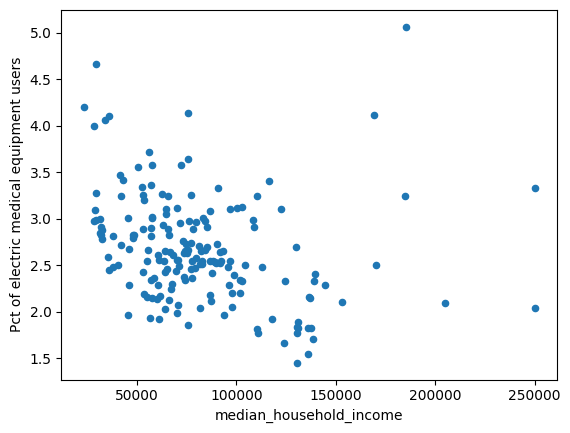

In [27]:
ax = dme_income_df.plot(x="median_household_income", y="August", kind="scatter")
ax.set_ylabel("Pct of electric medical equipment users")

In [28]:
dme_income_df.plot

In [75]:
dme_income_df

,Zip_Code,FIPS_Code,County_FIPS_Code,County,State_FIPS_Code,State,Jan_2022_Medicare_Benes,Jan_2022_Power_Dependent_Devices_DME,Feb_2022_Medicare_Benes,Feb_2022_Power_Dependent_Devices_DME,Mar_2022_Medicare_Benes,Mar_2022_Power_Dependent_Devices_DME,Apr_2022_Medicare_Benes,Apr_2022_Power_Dependent_Devices_DME,May_2022_Medicare_Benes,May_2022_Power_Dependent_Devices_DME,Jun_2022_Medicare_Benes,Jun_2022_Power_Dependent_Devices_DME,Jul_2022_Medicare_Benes,Jul_2022_Power_Dependent_Devices_DME,Aug_2022_Medicare_Benes,Aug_2022_Power_Dependent_Devices_DME,August,Unnamed: 0,Zipcode,Estimate,Margin of Error,Lower Estimate,Upper Estimate,geoid,median_household_income,"B19013001, Error"
0,10001,36061,61,New York,36,NY,4736,114,4720,107,4715,111,4720,119,4702,122,4683,118,4683,117,4677,119,2.544366,0,10001,25026,1759,23267,26785,86000US10001,96787.0,9861.0
1,10002,36061,61,New York,36,NY,18738,460,18731,445,18773,446,18799,458,18806,455,18786,465,18833,472,18867,488,2.586527,1,10002,74363,3183,71180,77546,86000US10002,35607.0,2214.0
2,10003,36061,61,New York,36,NY,8932,237,8913,235,8896,235,8907,229,8887,222,8888,229,8879,243,8878,239,2.692048,2,10003,54671,2568,52103,57239,86000US10003,129981.0,8865.0
3,10004,36061,61,New York,36,NY,811,16,807,17,809,17,808,18,809,16,812,16,812,19,810,17,2.098765,3,10004,3310,658,2652,3968,86000US10004,204949.0,12375.0
4,10005,36061,61,New York,36,NY,325,11,328,11,331,11,326,11,334,11,340,11,340,11,339,11,3.244838,4,10005,8664,906,7758,9570,86000US10005,184681.0,14575.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,11691,36081,81,Queens,36,NY,9788,323,9741,324,9749,318,9775,325,9814,330,9835,339,9860,334,9899,331,3.343772,209,11691,68454,3192,65262,71646,86000US11691,52605.0,3067.0
184,11692,36081,81,Queens,36,NY,2971,69,2972,68,2976,75,2984,79,2986,80,2986,89,2996,92,3006,98,3.260146,210,11692,22394,1856,20538,24250,86000US11692,53077.0,7883.0
185,11693,36081,81,Queens,36,NY,2427,71,2430,70,2425,70,2431,72,2443,72,2447,73,2456,71,2453,71,2.894415,211,11693,13029,1251,11778,14280,86000US11693,52946.0,12260.0
186,11694,36081,81,Queens,36,NY,4478,102,4468,105,4462,101,4479,107,4474,108,4477,109,4509,103,4519,109,2.412038,212,11694,21258,1683,19575,22941,86000US11694,87755.0,7930.0


In [29]:
income_df.geoid = income_df.geoid[-5:]

# Factor in age to the existing plot

In [49]:
import json

age_df = pd.read_csv("acs2020_5yr_B01001_86000US10460/acs2020_5yr_B01001_86000US10460.csv")

with open("acs2020_5yr_B01001_86000US10460/metadata.json") as f:
    metadata = json.load(f)

In [50]:
metadata

{'release': {'id': 'acs2020_5yr',
  'years': '2016-2020',
  'name': 'ACS 2020 5-year'},
 'tables': {'B01001': {'title': 'Sex by Age',
   'universe': 'Total Population',
   'denominator_column_id': 'B01001001',
   'columns': {'B01001001': {'name': 'Total:', 'indent': 0},
    'B01001002': {'name': 'Male:', 'indent': 1},
    'B01001003': {'name': 'Under 5 years', 'indent': 2},
    'B01001004': {'name': '5 to 9 years', 'indent': 2},
    'B01001005': {'name': '10 to 14 years', 'indent': 2},
    'B01001006': {'name': '15 to 17 years', 'indent': 2},
    'B01001007': {'name': '18 and 19 years', 'indent': 2},
    'B01001008': {'name': '20 years', 'indent': 2},
    'B01001009': {'name': '21 years', 'indent': 2},
    'B01001010': {'name': '22 to 24 years', 'indent': 2},
    'B01001011': {'name': '25 to 29 years', 'indent': 2},
    'B01001012': {'name': '30 to 34 years', 'indent': 2},
    'B01001013': {'name': '35 to 39 years', 'indent': 2},
    'B01001014': {'name': '40 to 44 years', 'indent': 2}

In [54]:
age_df

,geoid,name,Total:,"B01001001, Error",Male:,"B01001002, Error",Under 5 years,"B01001003, Error",5 to 9 years,"B01001004, Error",10 to 14 years,"B01001005, Error",15 to 17 years,"B01001006, Error",18 and 19 years,"B01001007, Error",20 years,"B01001008, Error",21 years,"B01001009, Error",22 to 24 years,"B01001010, Error",25 to 29 years,"B01001011, Error",30 to 34 years,"B01001012, Error",35 to 39 years,"B01001013, Error",40 to 44 years,"B01001014, Error",45 to 49 years,"B01001015, Error",50 to 54 years,"B01001016, Error",55 to 59 years,"B01001017, Error",60 and 61 years,"B01001018, Error",62 to 64 years,"B01001019, Error",65 and 66 years,"B01001020, Error",67 to 69 years,"B01001021, Error",70 to 74 years,"B01001022, Error",75 to 79 years,"B01001023, Error",80 to 84 years,"B01001024, Error",85 years and over,"B01001025, Error",Female:,"B01001026, Error",Under 5 years,"B01001027, Error",5 to 9 years,"B01001028, Error",10 to 14 years,"B01001029, Error",15 to 17 years,"B01001030, Error",18 and 19 years,"B01001031, Error",20 years,"B01001032, Error",21 years,"B01001033, Error",22 to 24 years,"B01001034, Error",25 to 29 years,"B01001035, Error",30 to 34 years,"B01001036, Error",35 to 39 years,"B01001037, Error",40 to 44 years,"B01001038, Error",45 to 49 years,"B01001039, Error",50 to 54 years,"B01001040, Error",55 to 59 years,"B01001041, Error",60 and 61 years,"B01001042, Error",62 to 64 years,"B01001043, Error",65 and 66 years,"B01001044, Error",67 to 69 years,"B01001045, Error",70 to 74 years,"B01001046, Error",75 to 79 years,"B01001047, Error",80 to 84 years,"B01001048, Error",85 years and over,"B01001049, Error"
0,86000US10001,10001,25026,1759,12265,1146,408,228,374,332,477,258,99,69,285,159,77,62,167,116,484,158,1308,355,1851,474,1027,310,1087,365,874,261,827,287,609,196,269,141,522,175,159,69,217,195,309,149,379,159,218,125,238,201,12761,1138,458,218,293,142,518,281,120,156,546,176,180,96,210,89,780,276,1848,457,1606,384,1037,452,798,338,784,278,720,251,500,142,463,230,256,151,192,109,166,99,378,150,358,141,171,87,379,178
1,86000US10002,10002,74363,3183,36656,2209,1164,351,1860,650,1852,438,725,246,452,149,421,163,449,166,1164,306,3678,791,3333,510,2215,434,2199,506,2525,425,2097,362,2703,550,708,224,1331,372,1247,413,1117,270,1586,338,1069,319,1453,362,1308,489,37707,1616,1077,415,1163,344,1351,328,541,198,643,224,218,144,632,308,1709,485,3391,562,2616,490,2206,524,2315,404,2262,320,2258,426,2501,428,1757,352,1196,271,1043,322,1598,424,2263,416,1443,305,1455,351,2069,443
2,86000US10003,10003,54671,2568,26671,1560,858,278,502,212,544,211,326,134,2741,305,798,204,481,173,1180,353,3663,712,3823,750,2193,469,1482,364,858,203,1562,390,1209,256,354,147,1073,349,414,175,666,248,662,193,640,220,327,153,315,107,28000,1855,691,241,317,126,321,278,364,257,3787,333,1031,328,640,222,1679,375,4423,1157,3509,782,1319,300,1220,306,980,294,1102,276,1316,343,563,203,838,248,464,184,872,295,894,249,782,263,384,170,504,198
3,86000US10004,10004,3310,658,1567,379,78,56,4,6,5,8,11,14,0,12,0,12,0,12,26,23,390,263,177,113,146,73,47,31,55,38,223,177,122,113,0,12,120,150,118,167,2,5,14,23,29,41,0,12,0,12,1743,393,30,31,49,33,43,47,24,39,81,96,6,9,3,6,51,73,335,182,129,59,124,64,112,76,153,120,193,180,140,147,67,86,88,104,3,6,39,44,38,44,0,12,0,12,35,46
4,86000US10005,10005,8664,906,4131,607,227,142,72,67,72,76,40,47,4,6,146,227,0,17,196,183,1072,345,650,252,502,213,320,140,321,155,302,211,145,121,30,49,0,17,0,17,10,11,22,34,0,17,0,17,0,17,4533,706,252,177,124,103,73,83,24,32,70,113,0,17,105,121,561,337,1151,366,826,285,332,166,506,220,94,66,96,81,193,177,65,105,1,4,0,17,7,10,29,41,24,40,0,17,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [52]:
name_of_cols = {k:v["name"] for k, v in metadata["tables"]["B01001"]["columns"].items()}

In [53]:
age_df.rename(columns=name_of_cols, inplace=True)

In [55]:
melted_age = age_df.melt(id_vars=['geoid', 'name'])

In [57]:
melted_age.variable.unique()

array(['Total:', 'B01001001, Error', 'Male:', 'B01001002, Error',
       'Under 5 years', 'B01001003, Error', '5 to 9 years',
       'B01001004, Error', '10 to 14 years', 'B01001005, Error',
       '15 to 17 years', 'B01001006, Error', '18 and 19 years',
       'B01001007, Error', '20 years', 'B01001008, Error', '21 years',
       'B01001009, Error', '22 to 24 years', 'B01001010, Error',
       '25 to 29 years', 'B01001011, Error', '30 to 34 years',
       'B01001012, Error', '35 to 39 years', 'B01001013, Error',
       '40 to 44 years', 'B01001014, Error', '45 to 49 years',
       'B01001015, Error', '50 to 54 years', 'B01001016, Error',
       '55 to 59 years', 'B01001017, Error', '60 and 61 years',
       'B01001018, Error', '62 to 64 years', 'B01001019, Error',
       '65 and 66 years', 'B01001020, Error', '67 to 69 years',
       'B01001021, Error', '70 to 74 years', 'B01001022, Error',
       '75 to 79 years', 'B01001023, Error', '80 to 84 years',
       'B01001024, Error', '85 y

In [58]:
pd.options.display.max_columns=None

pivoted_age = melted_age.pivot_table(index=["name", "geoid"], columns="variable", values="value", aggfunc="sum").reset_index()


In [61]:
pivoted_age

variable,name,geoid,10 to 14 years,15 to 17 years,18 and 19 years,20 years,21 years,22 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,5 to 9 years,50 to 54 years,55 to 59 years,60 and 61 years,62 to 64 years,65 and 66 years,67 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over,Female:,Male:,Total:,Under 5 years
0,10001,86000US10001,995,219,831,257,377,1264,3156,3457,2064,1885,1658,667,1547,1109,732,778,351,383,687,737,389,617,12761,12265,25026,866
1,10002,86000US10002,3203,1266,1095,639,1081,2873,7069,5949,4421,4514,4787,3023,4355,5204,2465,2527,2290,2715,3849,2512,2908,3377,37707,36656,74363,2241
2,10003,86000US10003,865,690,6528,1829,1121,2859,8086,7332,3512,2702,1838,819,2664,2525,917,1911,878,1538,1556,1422,711,819,28000,26671,54671,1549
3,10004,86000US10004,48,35,81,6,3,77,725,306,270,159,208,53,416,262,67,208,121,41,52,29,0,35,1743,1567,3310,108
4,10005,86000US10005,145,64,74,146,105,757,2223,1476,834,826,415,196,398,338,95,1,0,17,51,24,0,0,4533,4131,8664,479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,11691,86000US11691,5733,2766,1890,1287,778,2407,5313,4243,4043,2930,4060,6310,3879,4362,1550,1710,1664,1571,1904,1292,1232,1430,36449,32005,68454,6100
209,11692,86000US11692,2093,646,465,357,89,711,1279,1229,1863,1572,1498,1662,1186,1495,330,986,439,616,768,500,467,385,11464,10930,22394,1758
210,11693,86000US11693,730,413,209,153,106,386,996,707,859,601,711,918,1020,956,432,778,239,326,573,467,253,247,7180,5849,13029,949
211,11694,86000US11694,1617,670,308,255,70,700,867,1304,1543,950,1427,987,1925,2138,452,966,506,814,943,592,533,512,10653,10605,21258,1179


In [60]:
# Remove margin of error columns
pivoted_age.drop(list(pivoted_age.filter(regex = 'Error')), axis = 1, inplace = True)

In [62]:
pct_dict = {}

for col in pivoted_age.columns[4:-4]:
    pct_dict[col] = pivoted_age[col] / pivoted_age["Total:"]*100

In [63]:
pct_df = pd.DataFrame(pct_dict)

In [64]:
pct_df = pd.concat([pct_df, pd.DataFrame(pivoted_age.name)], axis=1)

In [65]:
pct_df.rename(columns={"name":"zip"}, inplace=True)

In [67]:
pct_df.columns

Index(['18 and 19 years', '20 years', '21 years', '22 to 24 years',
       '25 to 29 years', '30 to 34 years', '35 to 39 years', '40 to 44 years',
       '45 to 49 years', '5 to 9 years', '50 to 54 years', '55 to 59 years',
       '60 and 61 years', '62 to 64 years', '65 and 66 years',
       '67 to 69 years', '70 to 74 years', '75 to 79 years', '80 to 84 years',
       '85 years and over', 'zip'],
      dtype='object')

In [78]:
pct_df["percent_elderly"] = pct_df[['65 and 66 years','67 to 69 years', '70 to 74 years', '75 to 79 years', '80 to 84 years','85 years and over']].sum(axis=1)
merged_income_age = pct_df[["zip", "percent_elderly"]].merge(dme_income_df, left_on="zip", right_on="Zip_Code")
merged_income_age[["August", "median_household_income", "zip", "percent_elderly"]].to_csv("merged_income_age.csv")
